# Baysian Regression



Ici nous allons voir l'application de l'approche baysienne dans le cas d'une régression linaire simple. Pour illustrer cette example, nous allons utiliser le package `bmrs`.

Ce package est particulièrememt utile pour deux raisons. 

* **1)** Il constitue une interface conviviale qui permet d’écrire des modèles bayésiens dans le langage de R en s’appuyant sur la puissance du moteur de calcul de Stan. Stan est un langage de programmation probabiliste qui nous permet de implémenter les MCMCs pour le calcule de la distribution à posteriori. Il est écrit en `C++` mais qui peut être utilisé via différentes interfaces, notamment R, Python, Matlab, entre autres. Il existent différent type d'outils qui peuvent entre utilisé en R pour l'implémementation des MCMC comme par example (Win)BUGS ou JAGS. Par rapport à ces outils, Stan repose sur une méthode avancée appelée échantillonnage Hamiltonien dynamique qui lui permet de proposer une exploration plus efficace et plus rapide de l’espace des paramètres.


* **2)** En plus bmrs permet de spécifier des modèles des modèles de régression bayésienne de façon intuitive, en utilisant une syntaxe similaire à celle des regressions fréquentistes auxquelles nous avons l'habitude. Cela tout en profitant de l’efficacité et la robustesse des algorithmes de Stan pour l’estimation. Cette combinaison est particulièrement intéressante car elle vous donne accès non seulement aux modèles linéaires généralisés classiques (comme `lm` ou `lme`)  mais aussi aux modèles linéaires à effets mixtes (modèles hiérarchiques, comme `lmer`). Cela signifie que vous pouvez modéliser des structures de données plus complexes — par exemple, avec des effets aléatoires pour les participants ou les items — tout en adoptant une approche pleinement bayésienne.


## Quelque aspects techniques avant de commencer

La praticité de `bmrs` et `rstan` est souvant accompagné avec quelque soucies pour l'installation. Le code ci-dessous devrait marcher en principe, mais c'est tout à fait normale qui ça prenne quelque temps:

In [54]:
# Install brms and dependencies if not already installed
# Installe le package cmdstanr
#install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

# Installe CmdStan en local (nécessite internet et 5-10 minutes)
#cmdstanr::install_cmdstan(overwrite = TRUE)

# Vérifiez que tout fonctionne
cmdstanr::check_cmdstan_toolchain()
cmdstanr::cmdstan_version()



The C++ toolchain required for CmdStan is setup properly!



[1] "2.36.0"

In [107]:
# Load required packages

options(warn = -1)


library(brms)
library(cmdstanr)
library(bayesplot)
library(tidybayes)
library(modelr)

library(tidyverse)
library(ggplot2)


set.seed(1223) # cela a pour but de rendre les analyses reproducibles


This is bayesplot version 1.12.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attachement du package : ‘bayesplot’


L'objet suivant est masqué depuis ‘package:brms’:

    rhat




## Création d'un jeu de données simulé

Exactement comme dans le premier cours (motivations), nous allons simuler un jeu de données qui nous permettra de modifier facilement les caractéristiques de l'étude exemple et d'en observer les effets.

Dans cette étude exemple, nous allons simuler un jeu de données dans lequel nous mesurons les niveaux d'anxiété état avec la sous-échelle état du State-Trait Anxiety Questionnaire (STAI-State) et les niveaux socio-économiques de 120 participant-e-x-s. Le niveau socio-économique va de 1 à 20, 1 étant le niveau le plus bas et 20 le niveau le plus élevé. Le niveau d'anxiété état varie entre 20 et 80, avec des scores au-delà de 50 indiquant une souffrance importante.

Dans le jeu de données que nous allons simuler, nous allons aussi insérer une relation entre les scores d'anxiété et le niveau socio-économique.

In [52]:
# Nombre de participant-e-x-s
n <- 120

# Générer un statut socio-économique entre 1 et 20
socioecon <- rep(0:19, length.out = n)


# Simuler les scores d'anxiété avec une distribution gamma ajustée
base_anxiety <- round(qgamma(ppoints(n), shape = 10, scale = 100))  # Ajustement pour réduire les 20
base_anxiety <- scales::rescale(base_anxiety, to = c(20, 80))


# Générer des scores d’anxiété influencés par le statut socio-économique
anxiety_scores <- round(base_anxiety - socioecon * 2 + rnorm(n, 0, 5))
anxiety_scores <- anxiety_scores + 25

anxiety_scores <- pmax(pmin(anxiety_scores, 80), 20)


# Création du dataset final
simulated_data <- data.frame(
  sub_id = 1:n,                   # Identifiant des participant-e-x-s
  socioecon = socioecon,          # Statut socio-économique
  anxiety = anxiety_scores        # Score d'anxiété
)


simulated_data$sub_id <- factor(simulated_data$sub_id)

# Vérification des premières lignes
head(simulated_data)

,sub_id,socioecon,anxiety
,<fct>,<int>,<dbl>
1,1,0,47
2,2,1,43
3,3,2,40
4,4,3,39
5,5,4,47
6,6,5,45


## Definition des parametres du GLM

### Priors

Dans notre modèle de regression linaire simple, nous avons trois paramètres à estimer

Dans un modèle linéaire généralisé (GLM), nous cherchons à estimer trois paramètres principaux : $\beta_0$ (l'ordonnée à l'origine de la droite), $\beta_1$ (la pente de la droite), et **$\sigma$** (le paramètre de dispersion des données au tours de la droite, souvent assimilé à l'écart-type dans le cas d'une distribution normale des erreurs). 

Nous pouvons définir les connaissances a priori que nous possédons sur les trois paramètres du modèle avant même de recueillir les données. Pour cela, il est essentiel de réfléchir à ce que nous savons déjà sur notre variable dépendante. Dans notre cas, il s'agit du STAI-S, un questionnaire qui mesure l’anxiété-trait. Ce score varie entre 20 (niveau d’anxiété très faible) et 80 (niveau d’anxiété très élevé). La valeur moyenne du STAI-S peut différer selon divers facteurs tels que le sexe, l’âge ou encore le pays d’origine. Selon les études cela peut varier entre 45 et 50 avec des écarts-types assez larges, indiquant une variabilité notable entre les individus. 


#### $\beta_0$
L'interecept represente le niveau d'anxiété dans le niveau socio-économique le plus bas, nous pouvons donc imaginer que cela soit située un peu plus en haut que le niveau d'anxiété typiquement rapporté dans les études, mais nous allons garder un niveau d'uncertitude assez elevée. Nous pouvons modeliser cela avec un distribution normale centrée au tours de 50 avec un écart type de 20 (le double par rapport à l'écart-type typique).

Nous pouvons le visualiser comme il suit: 

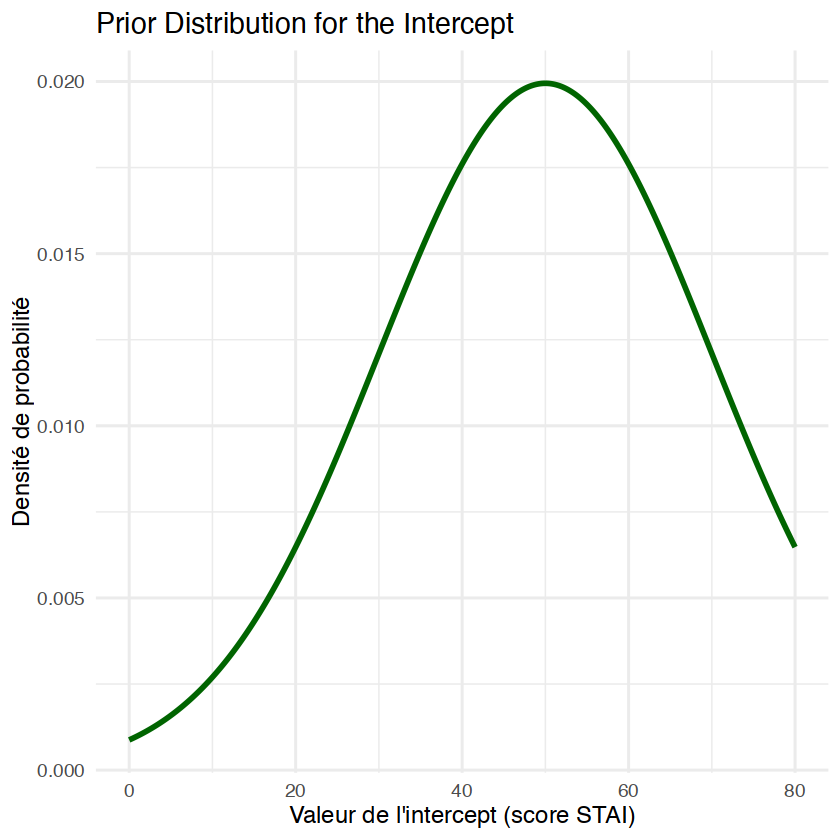

In [31]:
# Define the range of plausible intercept values
x_vals <- seq(0, 80, length.out = 1000)

# Compute the density for the normal prior N(40, 20)
prior_density <- dnorm(x_vals, mean = 50, sd = 20)

# Create a data frame
prior_df <- data.frame(
  intercept = x_vals,
  density = prior_density
)

# Generate the plot
ggplot(prior_df, aes(x = intercept, y = density)) +
  geom_line(color = "darkgreen", size = 1.2) +  # dark green line
  labs(
    title = "Prior Distribution for the Intercept",
    x = "Valeur de l'intercept (score STAI)",
    y = "Densité de probabilité"
  ) +
  theme_minimal(base_size = 14)

#### $\beta_1$

La pente coefficient de régression, c'est le paramètre qui représente le changement moyen de anxiété pour une unité de changement de niveau socio-economique. Pour établir le prior de cette paramètre, nous souhaitons conserver un haut niveau d’incertitude quant à la force de l’effet, afin de ne pas contraindre excessivement le modèle. Toutefois, sur la base de connaissances théoriques ou empiriques préalables, nous avons des raisons de penser que l’effet est plus probablement négatif que positif. Cela peut par exemple refléter une hypothèse selon laquelle une augmentation de la variable prédictive serait associée à une diminution du score de la variable dépendante. Ainsi, bien que le prior reste relativement large, il est légèrement asymétrique, en faveur de valeurs négatives. Nous pouvons encore faire appelle à une normale avec une moyenne de -2.5 (legèrement négative) et un écart-type de 5. Nous pouvons le visualiser comme il suit (pour visualiser l'asymetrie on met en évidance les valuers négatives.

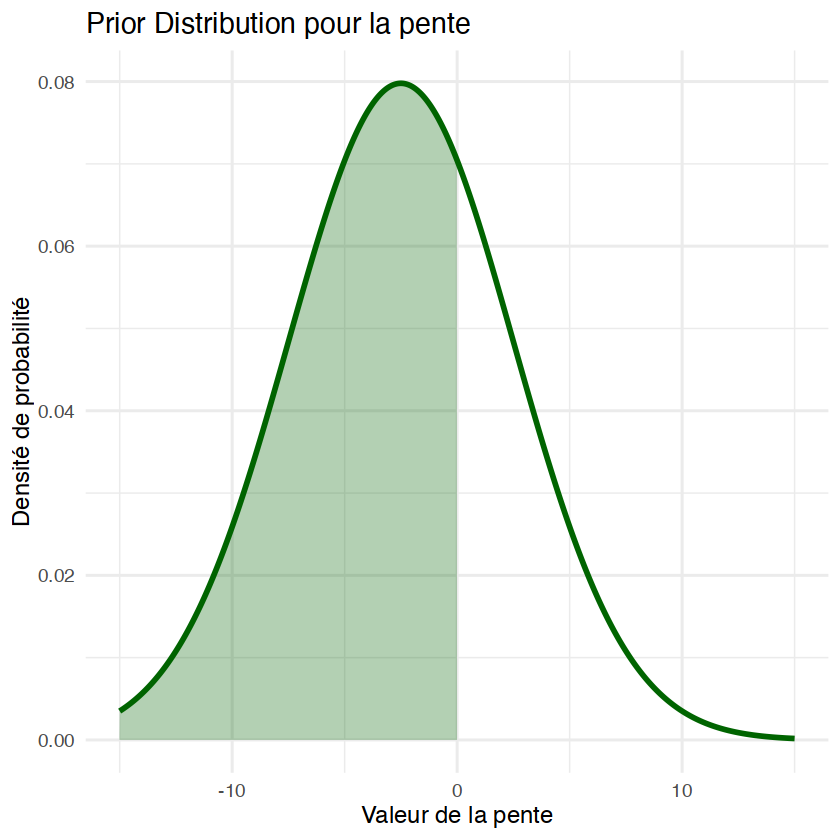

In [29]:
# valeur pour la pente
slope_vals <- seq(-15, 15, length.out = 1000)

# Densité pour le prior N(-2, 5)
slope_density <- dnorm(slope_vals, mean = -2.5, sd = 5)

# Créer un dataframe
slope_df <- data.frame(
  slope = slope_vals,
  density = slope_density
)

# Graphique avec zone ombrée pour les pentes négatives
ggplot(slope_df, aes(x = slope, y = density)) +
  geom_line(color = "darkgreen", size = 1.2) +  # très vert foncé
  geom_area(
    data = subset(slope_df, slope <= 0),
    aes(x = slope, y = density),
    fill = "darkgreen", alpha = 0.3
  ) +
  labs(
    title = "Prior Distribution pour la pente",
    x = "Valeur de la pente",
    y = "Densité de probabilité"
  ) +
  theme_minimal(base_size = 14)

#### $\sigma$

Ce paramètrereprésente l’erreur ou la dispersion autour de la prédiction de notre modèle, nous devons estimer dans quelle mesure les données observées sont susceptibles de s’écarter de la tendance générale. Nous savons que l'échelle du STAI-S varie entre 20 et 80 et que la variance typique (pas dans un modèle de regression) est de 10. Nous savons aussi que $\sigma$ a toujours de valeurs positives. 
Nous pouvons donc utilisé une distribution gamma (que nous avons pas vu en cours) pour determiner des valeurs qui sont positifs, avec un uncertitude large, mais en laissant moins de probabilité aux valeurs extrêmes (comme 0 ou au dessous de 50)

Nous pouvons visualiser cette distribution comme il suit:

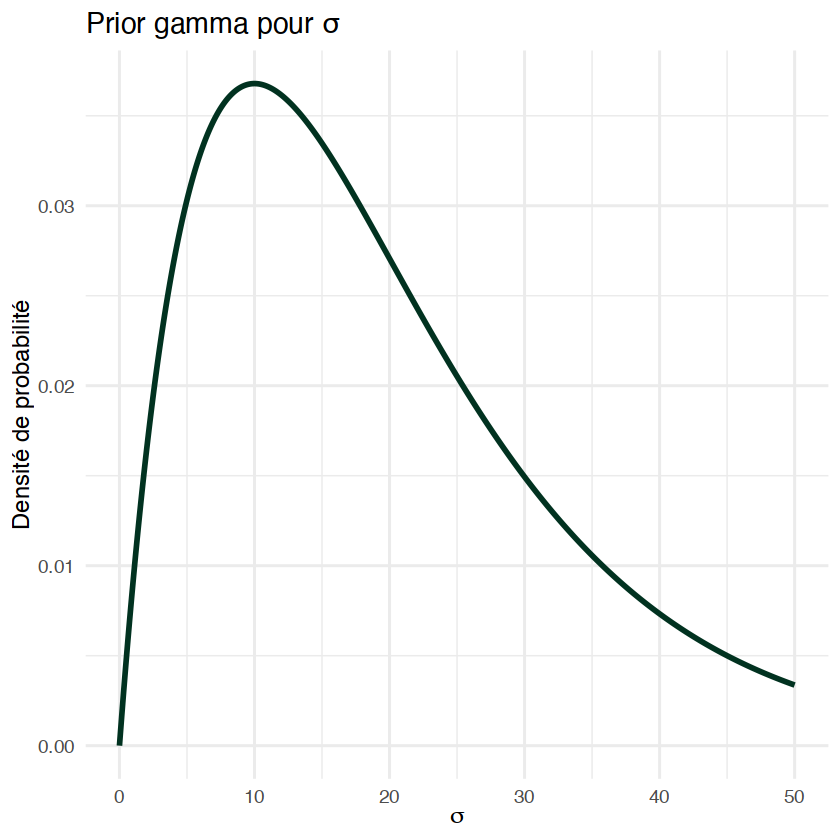

In [45]:
# Domaine de valeurs pour sigma
sigma_vals <- seq(0, 50, length.out = 1000)

# Densité de la gamma(2, 0.2)
sigma_density <- dgamma(sigma_vals, shape = 2, rate = 0.1)

# Créer un dataframe
sigma_df <- data.frame(
  sigma = sigma_vals,
  density = sigma_density
)

# Graphique
ggplot(sigma_df, aes(x = sigma, y = density)) +
  geom_line(color = "#013220", size = 1.2) +  # très vert foncé
  labs(
    title = "Prior gamma pour σ",
    x = expression(sigma),
    y = "Densité de probabilité"
  ) +
  theme_minimal(base_size = 14)

### mcmc

Les derniers paramètres que nous devons définir concernent le chaines MCMC: il y a plusieurs paramètres de configuration sont essentiels à comprendre. 

* Le paramètre `niter` correspond au nombre total d’itérations, c’est-à-dire le nombre de pas que chaque chaîne va effectuer pour explorer l’espace des paramètres.
  
*  Parmi ces itérations, une partie est réservée au `warmup` : ce sont les premiers pas effectués avant de commencer à enregistrer les échantillons. Ces itérations servent à ajuster l’algorithme (par exemple, à adapter la taille des pas) et sont exclues de l’inférence finale.

*  Enfin, le paramètre `chains` correspond au nombre de chaînes indépendantes lancées en parallèle. Chaque chaîne part d’un point différent et permet de vérifier la stabilité et la convergence du modèle. Si les chaînes donnent des résultats similaires malgré des points de départ différents, cela renforce la confiance dans les estimations produites.

Mai

In [60]:
# Fit the Bayesian linear regression
niter = 5000; warm = 1000; chains = 4; cores = 4; nsim = 40000 

bglm = brm(anxiety ~ socioecon, 
                  data=simulated_data, 
                  family = gaussian, 
                  priors <- c(
                  prior(normal(50, 20), class = "Intercept"),
                  prior(normal(-2.5, 5), class = "b", coef = "socioecon"),
                  prior(gamma(2, 0.1), class = "sigma")
                  ), 
                  sample_prior=TRUE, chains=4,
                  iter=niter, warmup=1000, seed=123, backend="cmdstanr",
                  control = list(adapt_delta = 0.99))

Start sampling



Running MCMC with 4 sequential chains...

Chain 1 Iteration:    1 / 5000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 5000 [  2%]  (Warmup) 
Chain 1 Iteration:  200 / 5000 [  4%]  (Warmup) 
Chain 1 Iteration:  300 / 5000 [  6%]  (Warmup) 
Chain 1 Iteration:  400 / 5000 [  8%]  (Warmup) 
Chain 1 Iteration:  500 / 5000 [ 10%]  (Warmup) 
Chain 1 Iteration:  600 / 5000 [ 12%]  (Warmup) 
Chain 1 Iteration:  700 / 5000 [ 14%]  (Warmup) 
Chain 1 Iteration:  800 / 5000 [ 16%]  (Warmup) 
Chain 1 Iteration:  900 / 5000 [ 18%]  (Warmup) 
Chain 1 Iteration: 1000 / 5000 [ 20%]  (Warmup) 
Chain 1 Iteration: 1001 / 5000 [ 20%]  (Sampling) 
Chain 1 Iteration: 1100 / 5000 [ 22%]  (Sampling) 
Chain 1 Iteration: 1200 / 5000 [ 24%]  (Sampling) 
Chain 1 Iteration: 1300 / 5000 [ 26%]  (Sampling) 
Chain 1 Iteration: 1400 / 5000 [ 28%]  (Sampling) 
Chain 1 Iteration: 1500 / 5000 [ 30%]  (Sampling) 
Chain 1 Iteration: 1600 / 5000 [ 32%]  (Sampling) 
Chain 1 Iteration: 1700 / 5000 [ 34%]  (Sampling) 
Chain 1 Ite

Le chargement a nécessité le package : rstan

Le chargement a nécessité le package : StanHeaders

rstan (Version 2.21.5, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attachement du package : ‘rstan’


L'objet suivant est masqué depuis ‘package:tidyr’:

    extract




In [ ]:
Ici nous avons 

In [62]:
# Posterior summaries
summary(bglm)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: anxiety ~ socioecon 
   Data: simulated_data (Number of observations: 120) 
  Draws: 4 chains, each with iter = 5000; warmup = 1000; thin = 1;
         total post-warmup draws = 16000

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    62.62      2.04    58.60    66.57 1.00    12798     9063
socioecon    -1.48      0.18    -1.84    -1.12 1.00    12599     9771

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    11.44      0.75    10.09    13.02 1.00    12285     9947

Draws were sampled using sample(hmc). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

Pour qu’un modèle bayésien produise des estimations fiables, il est essentiel que les chaînes MCMC aient convergé. Cela signifie que, malgré leurs points de départ différents, les chaînes ont toutes exploré la même région de l’espace des paramètres et échantillonnent à partir de la même distribution a posteriori. Si ce n’est pas le cas, les résultats risquent d’être biaisés ou incohérents.

Pour évaluer cette convergence, on utilise plusieurs outils :

* **1)** Le statistique `Rhat` (dans le tableau dessus) compare la variance entre les chaînes à la variance à l’intérieur de chaque chaîne. Une valeur proche de 1 (généralement < 1.01) indique que les chaînes ont convergé.

* **2)** Les statistiques `Bulk_ESS` et `Tail_ESS` (dans le tableau dessus) se refèrent à l ESS :Effective Sample Size ou taille d'échantillon effective. Cela indique combien d’échantillons indépendants l’algorithme a effectivement généré, après correction pour l’autocorrélation. Même si nous avons 20'000 échantillons (4 chaînes × 5000 itérations - 1000 warms up), l’ESS peut être beaucoup plus faible si nos chaînes sont fortement autocorrélées. Si le ESS est élevé les échantillons sont peu autocorrélés, donc l’estimation est précise, il est faible il y a une forte autocorrélation et donc l’inférence peut être peu fiable. Dans le cas spécifique `Bulk_ESS` c'est le nombre effectif d’échantillons pour l'estimation de la moyenne du paramètre, tandis que `Tail_ESS` c'est le nombre effectif d’échantillons pour estimer les queues (extrêmes) de la distribution. Gèneralement on veux que les valeurs de ces deux paramètres sont entre 400 et 1000.

* **3)** On peut examiner la densité marginale estimée pour chaque chaîne, comme dans le graphique ci-dessous:


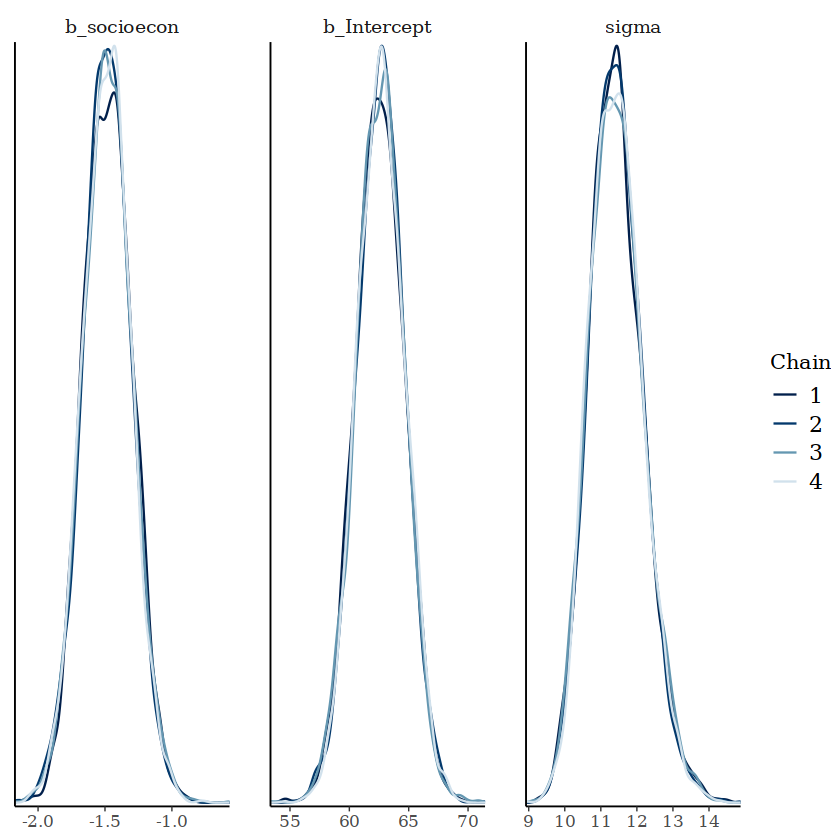

In [123]:
posterior_array <- as.array(bglm)
mcmc_dens_overlay(posterior_array,  pars = c("b_socioecon", "b_Intercept", "sigma"))

* **4)** On peut aussi examiner l’autocorrélation des échantillons, comme dans le graphique ci-dessous: Ce graphique montre à quel point les valeurs successives sont corrélées entre elles à différents lags (décalages). Une faible autocorrélation est souhaitable, car elle signifie que les chaînes explorent efficacement l’espace des paramètres.

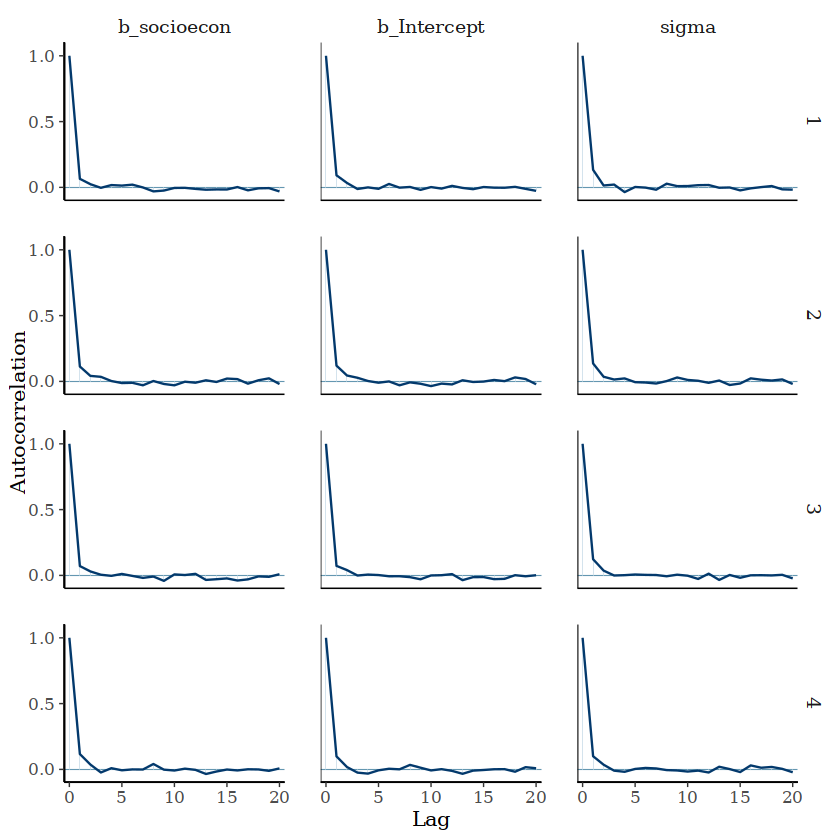

In [125]:
mcmc_acf(posterior_array, pars = c("b_socioecon", "b_Intercept", "sigma"))

* **5)** Le traceplot (ci dessous) permet de visualiser l’évolution des échantillons d’un paramètre à travers les itérations, pour chaque chaîne. Si les chaînes semblent "mélangées", sans tendance ou dérive, c’est un bon signe de convergence.

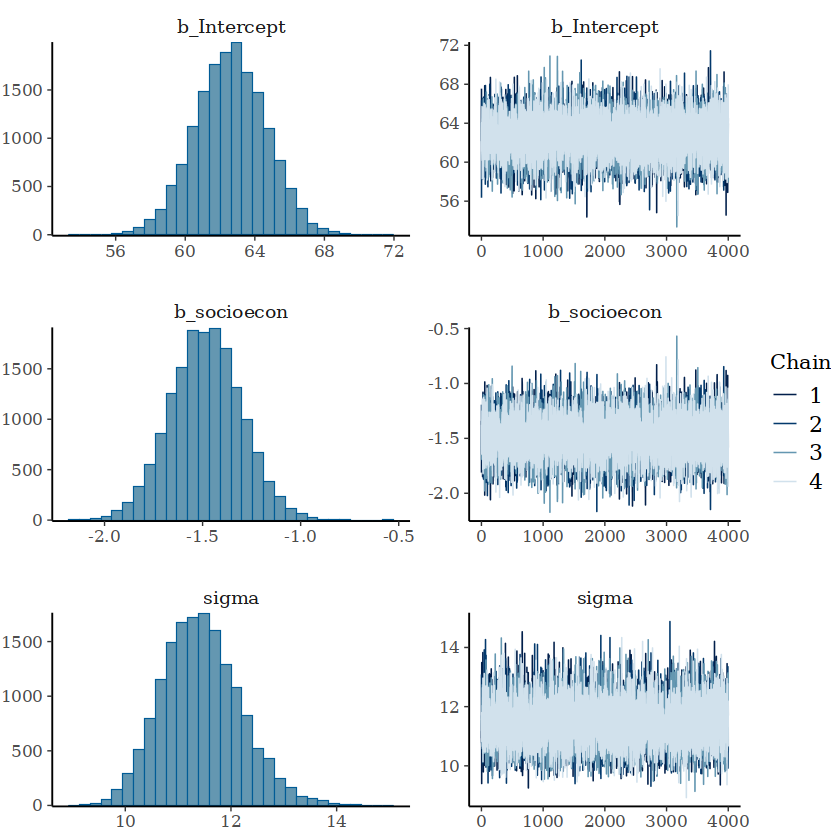

In [112]:
# Visual diagnostics
plot(bglm)

Pour avoir une idée de la précision des prédiction du modèle, nous pouvons aussi utiliser la function `pp_check`. Dans le graphique ci-dessous nous pouvons voir la distribution des données observées ($y$) et les distribution des donnée simulées à partir du modèle ajustén($\hat{y}$. Ces prédictions sont multiples (dans le cas du graphique ce dessous 10), parce que elles générées en tirand au hasard des valuers des paramètres ($\beta_0$, $\beta_1$, $\sigma$) dans les distribution à posteriori de ces paramètres.
Le graphique ci-dessous montre un très bon ajoustement du modèles aux données observée.

Using 10 posterior draws for ppc type 'dens_overlay' by default.



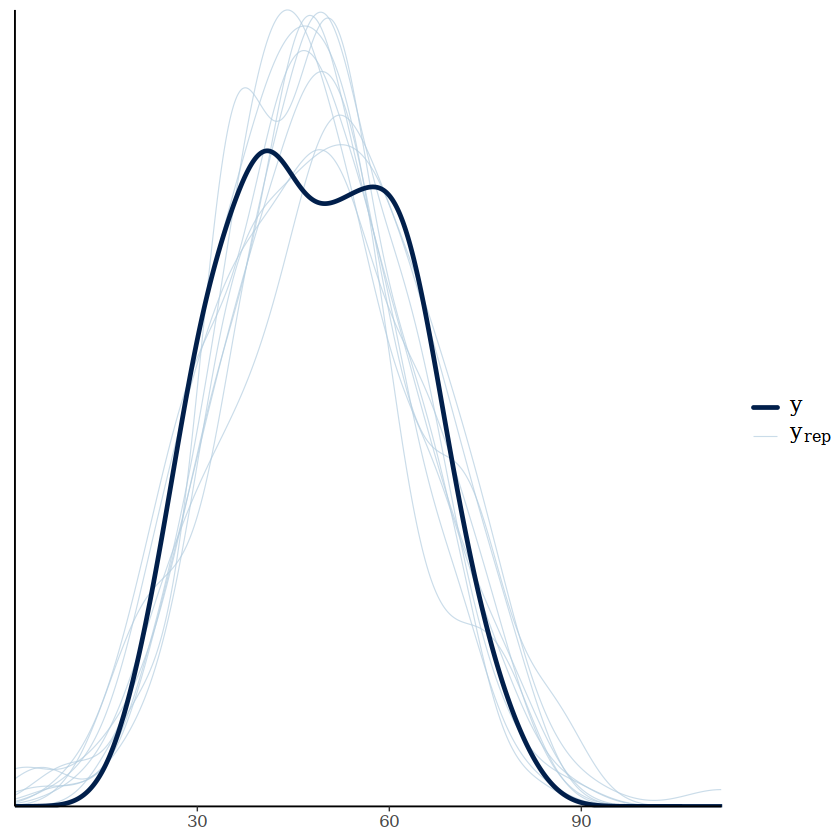

In [66]:
# Posterior predictive checks
pp_check(bglm)

Finalement, nous pouvons aussi representer graphiquement le résultat du modèle de manière plus classique avec les droite de regressions estimées  (par exemple on en génére 100) comme il suit : 

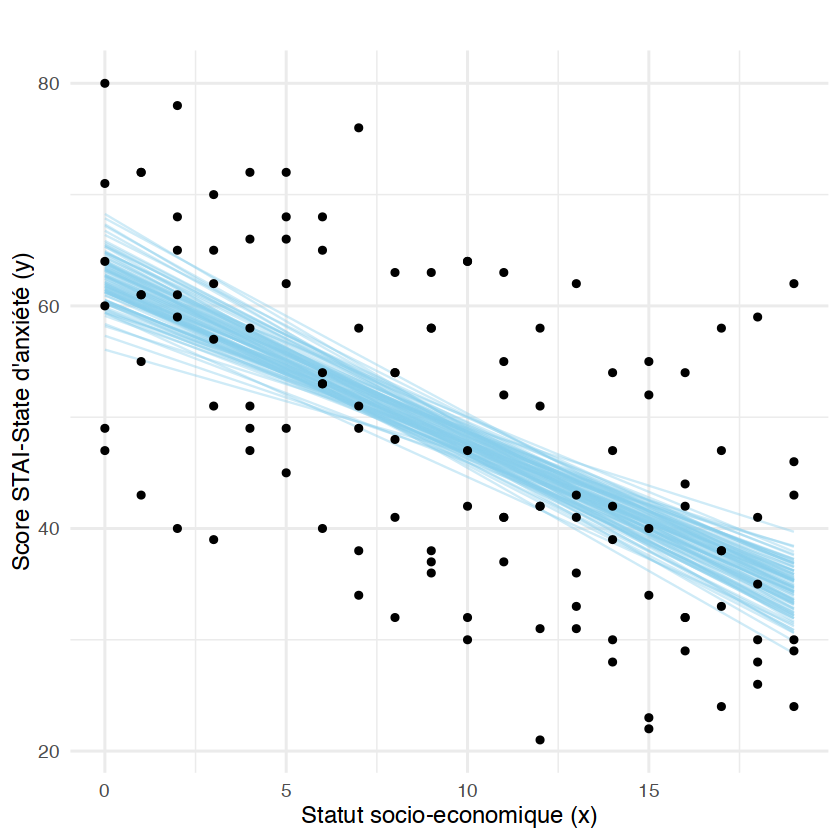

In [103]:
simulated_data %>%
  data_grid(socioecon = seq_range(socioecon, n = 100)) %>%
  add_fitted_draws(bglm, n = 100) %>%
  ggplot(aes(x = socioecon, y = .value)) +
  geom_line(aes(group = .draw), alpha = 0.4, color = "skyblue") +
  geom_point(data = simulated_data, aes(y = anxiety), color = "black", fill = "black", shape = 21) +
  labs(title = "",
       x = "Statut socio-economique (x)",
       y = "Score STAI-State d'anxiété (y)") +
  theme_minimal(base_size = 14)
